In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed

In [2]:
#Import Libraries

import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score
)
import shap

from xgboost import XGBClassifier

# For inline display
plt.style.use('seaborn-v0_8')


In [3]:
# Load Model and Test Data

X = np.load("/kaggle/input/model-evaluation/X_features.npy")
y = np.load("/kaggle/input/model-evaluation/y_labels.npy")

# Split test set (same as before)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Load the trained XGBoost model
with open("/kaggle/input/model-evaluation/trend_model (1).pkl", "rb") as f:
    model = pickle.load(f)

print("Model and data loaded successfully!")


Model and data loaded successfully!


[17:15:47] WARNING: /workspace/src/gbm/gbtree.cc:360: 
  Loading from a raw memory buffer (like pickle in Python, RDS in R) on a CPU-only
  machine. Consider using `save_model/load_model` instead. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.  Changing `tree_method` to `hist`.
[17:15:47] WARNING: /workspace/src/gbm/gbtree.cc:385: Changing updater from `grow_gpu_hist` to `grow_quantile_histmaker`.
[17:15:47] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.


In [4]:
# Evaluate Performance

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_proba)
avg_precision = average_precision_score(y_test, y_proba)

print(f"ROC-AUC Score: {roc_auc:.3f}")
print(f"Average Precision (PR AUC): {avg_precision:.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


ROC-AUC Score: 0.859
Average Precision (PR AUC): 0.624

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.86      0.90      3852
           1       0.47      0.69      0.55       680

    accuracy                           0.83      4532
   macro avg       0.70      0.77      0.73      4532
weighted avg       0.87      0.83      0.85      4532



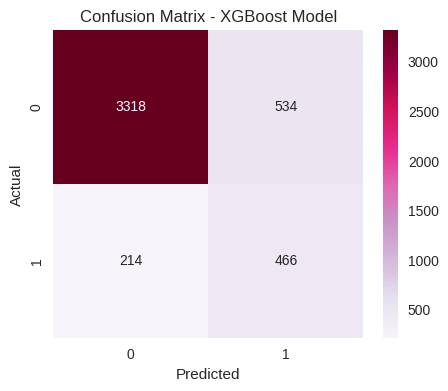

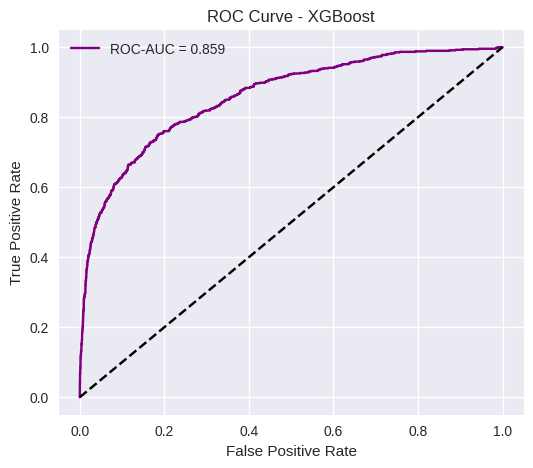

In [5]:
# Visual Evaluation-
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='PuRd')
plt.title("Confusion Matrix - XGBoost Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='purple', label=f"ROC-AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost")
plt.legend()
plt.show()


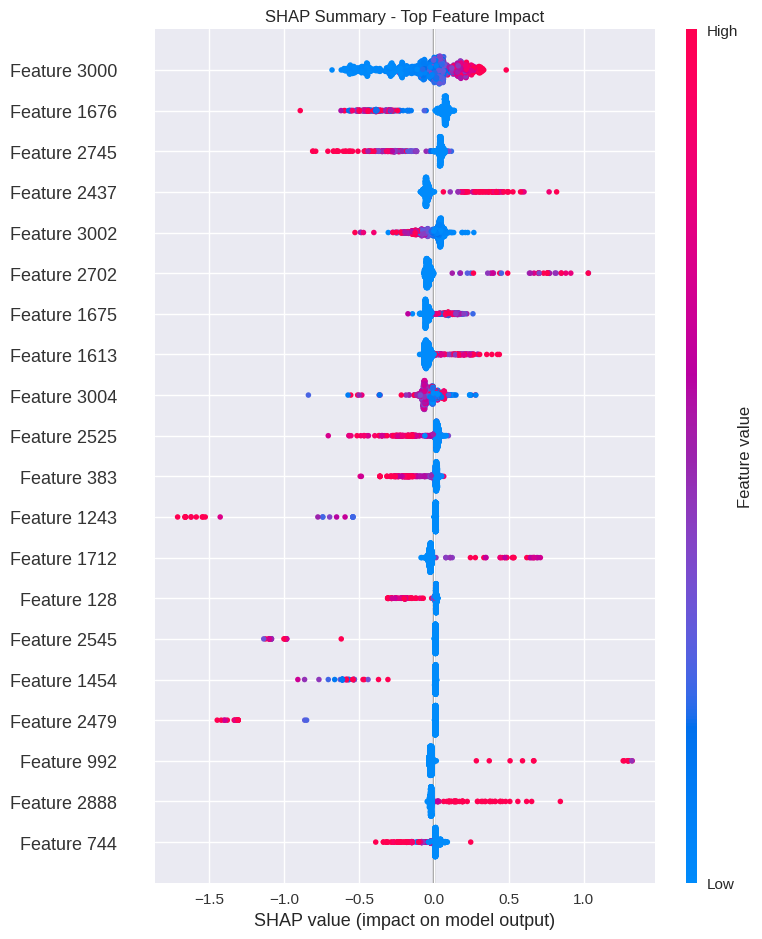

In [6]:
#  SHAP Explainability

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test[:1000])  # sample for speed

# Summary Plot (Feature Importance)
plt.title("SHAP Summary - Top Feature Impact")
shap.summary_plot(shap_values, X_test[:1000], show=False)
plt.savefig("/kaggle/working/shap_summary_plot.png", bbox_inches='tight')
plt.show()


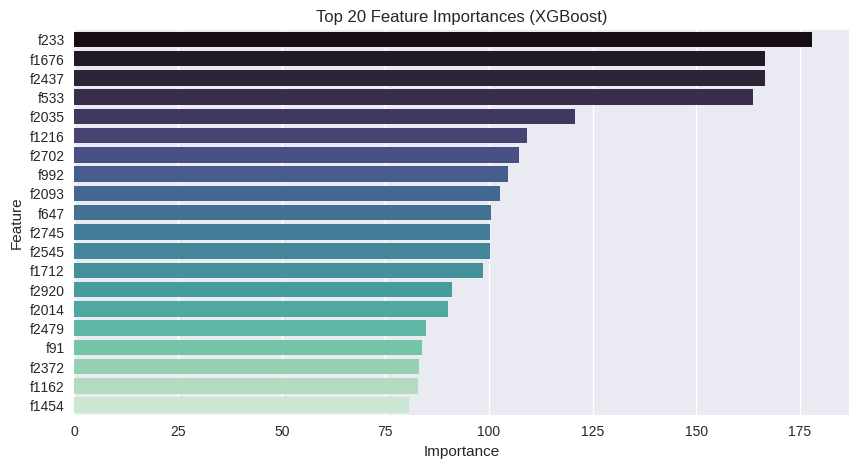

Feature importance saved for dashboard!


In [7]:
# Model Feature Importances

importance = model.get_booster().get_score(importance_type='gain')
importance_df = pd.DataFrame({
    'Feature': list(importance.keys()),
    'Importance': list(importance.values())
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20), palette='mako')
plt.title("Top 20 Feature Importances (XGBoost)")
plt.show()

# Save for dashboard integration
importance_df.to_csv("/kaggle/working/feature_importance.csv", index=False)
print("Feature importance saved for dashboard!")


In [9]:
#Save Evaluation Report
metrics_report = {
    "ROC_AUC": round(roc_auc, 3),
    "Average_Precision": round(avg_precision, 3),
    "Confusion_Matrix": cm.tolist(),
}

import json
with open("/kaggle/working/evaluation_report.json", "w") as f:
    json.dump(metrics_report, f, indent=4)

print("✅ Evaluation report saved (evaluation_report.json)")


✅ Evaluation report saved (evaluation_report.json)
